# London Smart meters dataset

https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

## Transform extracting features with TSFEL

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
import tsfel

In [3]:
DATASET_ID = 0 # 'FULL'
DECIMATION_RATE = 0.1 # valid only if dataset is FULL

In [4]:
dataset_root = Path('../../Dataset')

In [5]:
if isinstance( DATASET_ID, int )  :
    dataset = sorted(list((dataset_root/'partitioned/Small LCL Data').glob('*.csv')))[ DATASET_ID ]
else :
    dataset = dataset_root/'full/CC_LCL-FullData.csv'

In [6]:
%%time
df = pd.read_csv(dataset, names = ['ID','type','timestamp','consumption'], header = 0) 

CPU times: user 415 ms, sys: 44.8 ms, total: 460 ms
Wall time: 460 ms


In [7]:
ids = df.ID.unique()
if not isinstance( DATASET_ID, int )  :
    ids = np.random.choice( ids, int( len(ids) * DECIMATION_RATE ) )
    df = df.query( 'ID in @ids' )

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   ID           1000000 non-null  object
 1   type         1000000 non-null  object
 2   timestamp    1000000 non-null  object
 3   consumption  1000000 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [9]:
%%time
df = (df
      .assign( timestamp = pd.to_datetime(df.timestamp) )
      .assign( consumption = pd.to_numeric( df.consumption, errors = 'coerce' ) )
      .assign( invalid = lambda x : x.consumption.isna() )
#      .assign( consumption = lambda x : x.consumption.fillna( -1.0 ) )
    )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   ID           1000000 non-null  object        
 1   type         1000000 non-null  object        
 2   timestamp    1000000 non-null  datetime64[ns]
 3   consumption  999971 non-null   float64       
 4   invalid      1000000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), object(2)
memory usage: 31.5+ MB
CPU times: user 404 ms, sys: 19.8 ms, total: 424 ms
Wall time: 423 ms


In [10]:
df.tail()

,ID,type,timestamp,consumption,invalid
999995,MAC000036,Std,2012-11-08 08:00:00,0.228,False
999996,MAC000036,Std,2012-11-08 08:30:00,0.042,False
999997,MAC000036,Std,2012-11-08 09:00:00,0.076,False
999998,MAC000036,Std,2012-11-08 09:30:00,0.070,False
999999,MAC000036,Std,2012-11-08 10:00:00,0.005,False


In [11]:
%%time
df_series = (  df
               .assign( year = df.timestamp.dt.year.astype( str ) )
               .assign( month = df.timestamp.dt.month.apply( lambda d : f'{d:02d}' ) ) 
               .assign( day = df.timestamp.dt.day.apply( lambda d : f'{d:02d}' ) ) 
               .assign( time = df.timestamp.dt.time.astype( str ) )
               .assign( year_month = lambda x : x.year.str.cat( x.month, sep = '-' ) )
               .assign( day_time = lambda x : x.day.str.cat( x.time, sep = '-' ) )
               .assign( sample_name = lambda x : x.ID.str.cat( x.year_month, sep = '-' ) )
               [['sample_name','day_time','consumption']]
               .groupby( ['sample_name','day_time'] )
               .sum()
               .unstack( 'day_time' )
               .droplevel(0, axis = 1)
            )


CPU times: user 3.01 s, sys: 392 ms, total: 3.4 s
Wall time: 3.4 s


In [12]:
# build a dataframe as required by tsfel to extract features:
# rows are timestamps and columns are series names
X = df_series.T.fillna(0)

# uncomment the following to reduce the samples to a subset, to explore results
# choosen_idxs = np.random.choice(len(df_series), size = 15, replace = False)
# X = df_series.iloc[choosen_idxs].T.droplevel(0).fillna(0)

In [13]:
X.head()

sample_name,MAC000002-2012-10,MAC000002-2012-11,MAC000002-2012-12,MAC000002-2013-01,MAC000002-2013-02,MAC000002-2013-03,MAC000002-2013-04,MAC000002-2013-05,MAC000002-2013-06,MAC000002-2013-07,...,MAC000036-2012-02,MAC000036-2012-03,MAC000036-2012-04,MAC000036-2012-05,MAC000036-2012-06,MAC000036-2012-07,MAC000036-2012-08,MAC000036-2012-09,MAC000036-2012-10,MAC000036-2012-11
day_time,,,,,,,,,,,,,,,,,,,,,
01-00:00:00,0.0,0.252,0.215,0.219,0.215,0.483,0.069,0.226,0.214,0.156,...,0.000,0.008,0.024,0.004,0.040,0.000,0.000,0.000,0.006,0.060
01-00:30:00,0.0,0.241,0.217,0.241,0.284,0.339,0.140,0.186,0.263,0.111,...,0.000,0.003,0.000,0.000,0.053,0.055,0.063,0.045,0.006,0.006
01-01:00:00,0.0,0.230,0.237,0.191,0.313,0.299,0.068,0.207,0.235,0.110,...,0.001,0.027,0.000,0.032,0.000,0.029,0.015,0.031,0.052,0.006
01-01:30:00,0.0,0.209,0.204,0.235,0.286,0.263,0.139,0.173,0.263,0.116,...,0.048,0.033,0.058,0.038,0.000,0.000,0.000,0.000,0.037,0.019
01-02:00:00,0.0,0.231,0.243,0.182,0.204,0.225,0.069,0.100,0.231,0.098,...,0.000,0.000,0.000,0.000,0.062,0.033,0.045,0.016,0.006,0.063


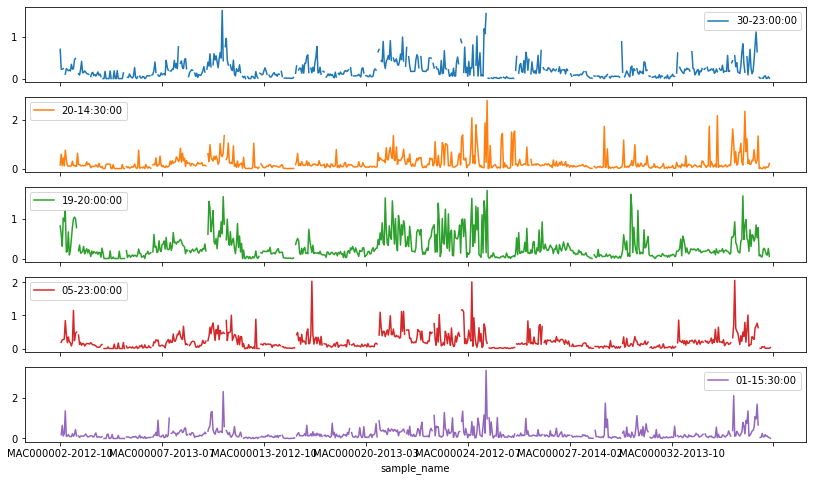

In [14]:
# Show some ranomd series
df_series.T.sample(5).T.plot( figsize = (14,8), subplots = True )
plt.show()

In [15]:
# synthetic dataset used to check columns ordering
# X = pd.concat([pd.Series([0]*10) for _ in range(10)] + [pd.Series([10]*10) for _ in range(2)], axis = 1)
# X.columns = [f'serie_{x}' for x in range(12)]
# X

In [16]:
# build config file to drive tsfel 

#cfg_file = tsfel.get_features_by_domain()               # All features will be extracted.
#cfg_file = tsfel.get_features_by_domain("statistical")  # All statistical domain features will be extracted
#cfg_file = tsfel.get_features_by_domain("temporal")     # All temporal domain features will be extracted
#cfg_file = tsfel.get_features_by_domain("spectral")     # All spectral domain features will be extracted

#domain = "statistical"
#domain = "temporal"
#domain = "spectral"
domain = None

cfg_file = tsfel.get_features_by_domain(domain)               


In [17]:
# Xf is the feature extraction dataset from tsfel
# it is a single row of features with feature names in the format f'{s}_{name}' 
# where 's' is the column number in the original dataset and 'name' is the feature name.
# Feratures are orederd in alphabetical order thus features of column #11 come after 
# features of column #1
# This is beacuse tsfel is designed with multivariate ts in mind, not multiple ts.

Xf = tsfel.time_series_features_extractor(cfg_file, X ) 

*** Feature extraction started ***
60


/tmp/ipykernel_86132/3264033782.py:8: UserWarning: Using default sampling frequency set in configuration file.
  Xf = tsfel.time_series_features_extractor(cfg_file, X )



*** Feature extraction finished ***


In [18]:
Xf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 272220 entries, 0_Absolute energy to 9_Zero crossing rate
dtypes: float64(272220)
memory usage: 2.1 MB


In [19]:
# Convert the features row in a features table with time series in the rows and relevent features in the columns
df_features = ( Xf
  .T    # Transpose to have the columns as index
  .set_index( pd.MultiIndex.from_tuples( \
      [(int(i),s) for i,s in [re.match(r'(\d+)_(.+)',idx).groups() for idx in Xf.columns]]
   ))  # build a mulitindex from the current index
  .T   # Set the index back on the columns
  .stack(0)     # Level 0 of multiindex columns is the time series number in the order of the original dataset
  .droplevel(0) # index level 0 is just '0' because Xf had only one row
  .sort_index() # probably useless but there is noguarantee about column order from tsfel
  .set_index(X.columns) # rename the index as the names of the time series
)

In [20]:
df_features

,Absolute energy,Area under the curve,Autocorrelation,Centroid,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,ECDF_1,...,Wavelet variance_0,Wavelet variance_1,Wavelet variance_2,Wavelet variance_3,Wavelet variance_4,Wavelet variance_5,Wavelet variance_6,Wavelet variance_7,Wavelet variance_8,Zero crossing rate
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000002-2012-10,143.028305,2.776200,143.028305,10.898703,299.0,1196.0,0.000,0.307,0.000669,0.001338,...,0.020536,0.041642,0.076114,0.118772,0.159664,0.187189,0.199345,0.203901,0.209303,5.0
MAC000002-2012-11,142.307686,3.448940,142.307686,6.714764,299.0,1196.0,0.103,0.289,0.000669,0.001338,...,0.030100,0.042896,0.057508,0.077917,0.095408,0.108746,0.120687,0.133895,0.149320,9.0
MAC000002-2012-12,151.318359,3.555400,151.318359,7.013707,299.0,1196.0,0.104,0.293,0.000669,0.001338,...,0.031424,0.050123,0.071109,0.094537,0.114834,0.131182,0.146861,0.164570,0.184545,6.0
MAC000002-2013-01,154.403864,3.598440,154.403864,7.811695,299.0,1196.0,0.109,0.278,0.000669,0.001338,...,0.031152,0.054426,0.069617,0.089890,0.116362,0.145060,0.173281,0.200144,0.225378,4.0
MAC000002-2013-02,238.548989,3.817305,238.548989,8.363299,299.0,1196.0,0.088,0.288,0.000669,0.001338,...,0.038880,0.085373,0.162035,0.242712,0.310418,0.366311,0.415521,0.460266,0.502049,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000036-2012-07,10.944161,0.871740,10.944161,7.567055,299.0,1196.0,0.006,0.083,0.000669,0.001338,...,0.003644,0.004351,0.005060,0.006127,0.007809,0.009306,0.009966,0.010026,0.010048,341.0
MAC000036-2012-08,12.477560,0.940690,12.477560,7.373486,299.0,1196.0,0.011,0.089,0.000669,0.001338,...,0.004342,0.004727,0.005289,0.005549,0.006693,0.008213,0.009467,0.010532,0.011682,307.0
MAC000036-2012-09,9.686995,0.822190,9.686995,6.869148,299.0,1196.0,0.005,0.080,0.000669,0.001338,...,0.003299,0.003054,0.003673,0.004611,0.006145,0.007606,0.008509,0.009030,0.009530,282.0


# Save ingested data

In [21]:
if domain is None :
    domain = 'all'
    
if isinstance( DATASET_ID, int )  :
    out_file_series = f'ingested/series_{DATASET_ID}.csv' 
    out_file_features = f'ingested/fsfel_{domain}_features_{DATASET_ID}.csv' 
else :
    out_file_series = f'ingested/series_full_{DECIMATION_RATE}.csv' 
    out_file_features = f'ingested/fsfel_features_full_{DECIMATION_RATE}.csv' 
    
df_series.to_csv( dataset_root/out_file_series )
print(f'Series dataframe saved to {dataset_root/out_file_series}')

df_features.to_csv( dataset_root/out_file_features )
print(f'Features dataframe saved to {dataset_root/out_file_features}')


Series dataframe saved to ../../Dataset/ingested/series_0.csv
Features dataframe saved to ../../Dataset/ingested/fsfel_all_features_0.csv
